# Image Pipeline Optimization Across Multiple LLM Models
This notebook applies the image processing pipeline and hyperparameter optimization using different LLM models (Llama3.2-vision:11b, deepseekr1:8b, deepseekr1:14b) via Ollama.

In [3]:
# tested in python >= 3.12, < 3.13, use main pyproject.toml
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [ ]:
# Imports and setup
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pprint
import json
import random
from lib.image.llm_pipeline import optimize_pipeline, build_pipeline, process_image

# Ollama client
from ollama import chat

In [ ]:
# Define LLM models to test
models = [
    "llama3.2-vision:11b",
    "deepseek-r1:8b",
    "deepseek-r1:32b"
]

param_space = {
    "denoise": {"h": [5, 10, 15], "template_window": [3, 7]},
    "contrast": {"alpha": [1.0, 1.2, 1.5], "beta": [0, 10, 20]},
    "resize": {"width": [800, 1024, 1280]},
    "normalize": {"clipLimit": [1.0, 2.0], "tileGrid": [(8, 8)]},
    "crop": {"margin": [0, 5, 10]},
    "hash": {}
}

## Generacion random de la config del pipeline

In [ ]:
def generate_random_config():
    return {
        "use": {
            "rotate": random.choice([True, False]),
            "denoise": True,
            "contrast": random.choice([True, False]),
            "resize": True,
            "normalize": True,
            "crop": random.choice([True, False]),
            "hash": True
        },
        "params": {
            "denoise": {"h": 10, "template_window": 7},
            "contrast": {"alpha": 1.2, "beta": 10},
            "resize": {"width": 1024},
            "normalize": {"clipLimit": 2.0, "tileGrid": (8, 8)},
            "crop": {"margin": 5}
        }
    }

## Prompt para configurar el pipeline via LLM

In [7]:
prompt = f"""
  An image was processed and the following metrics were evaluated:

  - Blur reduction: {data['metrics']['blur_reduction']:.2f}
  - OCR gain: {data['metrics']['ocr_gain']}
  - Overall score: {data['metrics']['score']:.2f}

  These were the initial parameters used:
  {json.dumps(data['params'], indent=2)}

  Decide which steps should be enabled based on the state of the processed image and its visual quality.
  Respond only with JSON format as in the following example:

  {{
    "use": {{
      "rotate": false,
      "denoise": true,
      "contrast": true,
      "resize": true,
      "normalize": true,
      "crop": false,
      "hash": true
    }},
    "params": {{
      "denoise": {{ "h": 10, "template_window": 7 }},
      "contrast": {{ "alpha": 1.2, "beta": 10 }},
      "resize": {{ "width": 1024 }},
      "normalize": {{ "clipLimit": 2.0, "tileGrid": [8, 8] }},
      "crop": {{ "margin": 5 }}
    }}
  }}
"""

NameError: name 'metrics' is not defined

In [ ]:
def llm_adjust_callback(data, model_name="llama3.2:3b", custom_prompt):
    response = chat(
        model=model_name,
        messages=[{"role": "user", "content": custom_prompt}]
    )
    try:
        parsed = json.loads(response['message']['content'])
    except Exception as e:
        
        parsed = generate_random_config()
    return parsed

## Generamos los steps dados por la LLM

In [ ]:
steps = build_pipeline(config)

## Generamos el pipeline CUSTOM por LLM

In [ ]:
processed_img, history = process_image(orig, steps)

In [13]:
# Define the LLM adjustment callback
def llm_adjust_callback(data, model_name):
    if not model_name:
        raise ValueError("Model name is required for LLM adjustment.")
    prompt = f"""La imagen procesada tiene métricas:
- Reducción de blur: {data['metrics']['blur_reduction']:.2f}
- Ganancia OCR: {data['metrics']['ocr_gain']}

Original params: {data['params']}

Sugiere nuevos hiperparámetros para mejorar la calidad de la imagen."""
    response = chat(
    model=model_name,
    messages=[{"role": "user", "content": prompt}]
)
    # Here you would parse the response back into a params dict
    # For now, return original params
    return data['params']

Model: llama3.2:3b, Score: -266.51419960207664


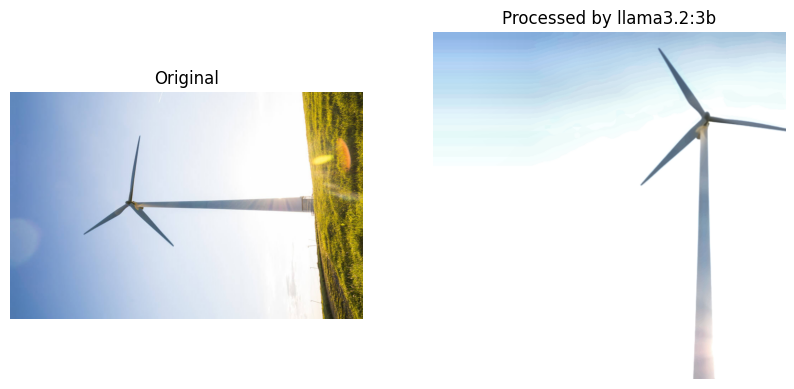

Model: llama3.2-vision:11b, Score: -265.56741698359275


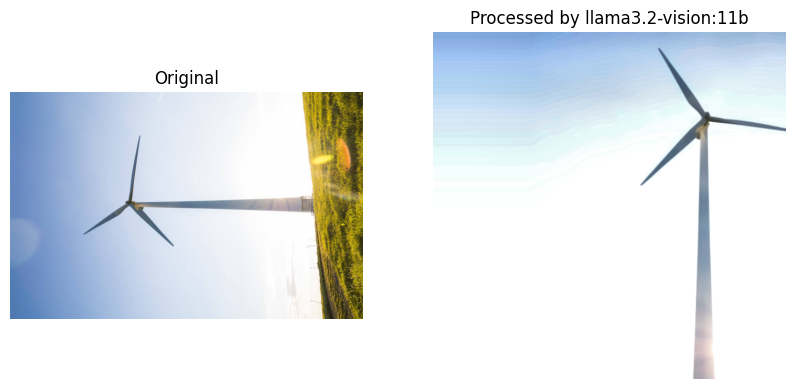

Model: deepseek-r1:8b, Score: -269.3443882283409


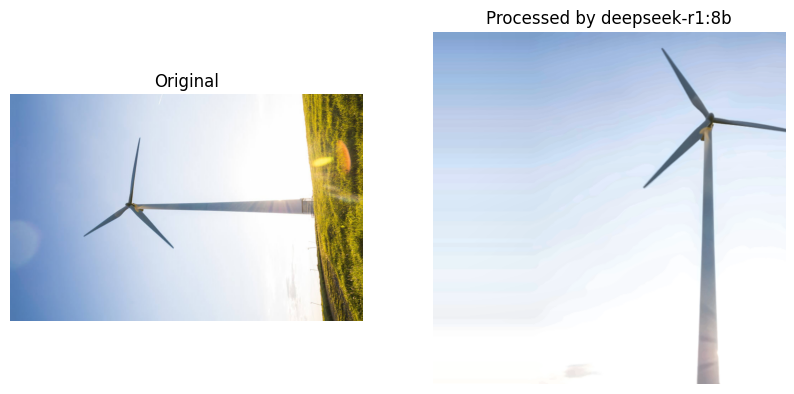

Model: deepseek-r1:32b, Score: -252.26816495989934


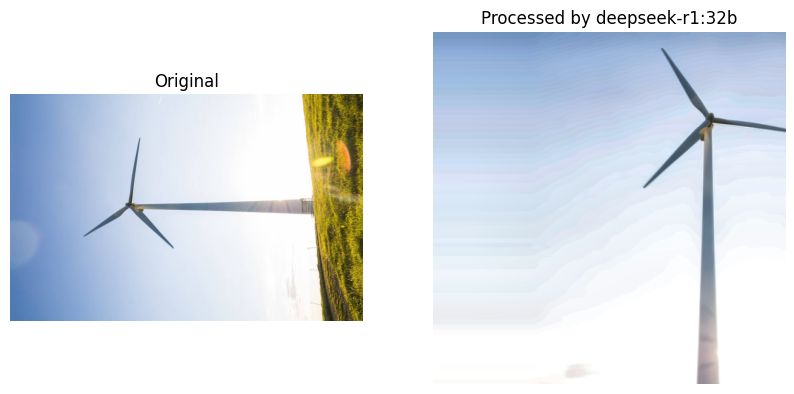

In [18]:
# Load an example image
image_dir = os.path.join(project_root, 'samples', 'data', 'images', 'img_pipeline')
img_path = 'rotated.jpg'
img_path = os.path.join(image_dir, img_path)
orig = cv2.imread(img_path)
if orig is None:
    raise FileNotFoundError(f"Image not found at {img_path}")
results = {}

for model_name in models:
    pprint(f"Testing model: {model_name}")
    best = optimize_pipeline(orig, param_space, lambda d: llm_adjust_callback(d, model_name), max_iter=3)
    results[model_name] = best

# Display results
for model_name, res in results.items():
    print(f"Model: {model_name}, Score: {res['metrics']['score']}")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(cv2.cvtColor(res['image'], cv2.COLOR_BGR2RGB))
    ax2.set_title(f"Processed by {model_name}")
    ax2.axis('off')
    plt.show()